In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [2]:
data_file = "../csv/metro/Metro_Interstate_Traffic_Volume.csv"
dataset = pd.read_csv(data_file, index_col='date_time', usecols=['traffic_volume', 'date_time', 'holiday', 'temp'])
ds = dataset.copy()
ds

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545
2012-10-02 10:00:00,None,289.36,4516
2012-10-02 11:00:00,None,289.58,4767
2012-10-02 12:00:00,None,290.13,5026
2012-10-02 13:00:00,None,291.14,4918
...,...,...,...
2018-09-30 19:00:00,None,283.45,3543
2018-09-30 20:00:00,None,282.76,2781
2018-09-30 21:00:00,None,282.73,2159


In [3]:
ds.drop_duplicates(inplace=True)

In [4]:
ds.sort_index

<bound method DataFrame.sort_index of                     holiday    temp  traffic_volume
date_time                                          
2012-10-02 09:00:00    None  288.28            5545
2012-10-02 10:00:00    None  289.36            4516
2012-10-02 11:00:00    None  289.58            4767
2012-10-02 12:00:00    None  290.13            5026
2012-10-02 13:00:00    None  291.14            4918
...                     ...     ...             ...
2018-09-30 19:00:00    None  283.45            3543
2018-09-30 20:00:00    None  282.76            2781
2018-09-30 21:00:00    None  282.73            2159
2018-09-30 22:00:00    None  282.09            1450
2018-09-30 23:00:00    None  282.12             954

[40606 rows x 3 columns]>

### Проверим, являются ли интервалы равномерными

In [5]:
from datetime import datetime 

def are_intervals_smooth(data):
    is_smooth = True
    not_smooth_interval_count = 0
    sorted_ds = data.sort_index()
    intervals= []
    for first, second in zip(sorted_ds.iloc[0::, :].index, sorted_ds.iloc[1::, :].index):
        first = datetime.strptime(first, '%Y-%m-%d %H:%M:%S')
        second = datetime.strptime(second, '%Y-%m-%d %H:%M:%S')
        if (second - first).seconds // 3600 > 1:
            intervals.append((second - first).seconds // 3600)
            is_smooth = False
            not_smooth_interval_count = not_smooth_interval_count + 1
    if intervals:
        print(max(intervals))
    return (is_smooth, not_smooth_interval_count)
        
print(are_intervals_smooth(ds))

23
(False, 2625)


### Пройдем по всем интервалам, если такой записи нет, добавим, потом с помозью интерполяции заполним пропуски

In [6]:
import tqdm

def get_datetime_str(dt):
    return 

date_times =[]
for interval in tqdm.tqdm(pd.date_range(min(ds.index), max(ds.index),freq="H")):
    if str(interval) not in ds.index:
        date_times.append(interval.strftime('%Y-%m-%d %H:%M:%S'))

data = pd.DataFrame.from_dict({'date_time': np.array(date_times),
                               'holiday':np.array([np.nan] * len(date_times)),
                               'temp': np.array([np.nan] * len(date_times) ),
                               'traffic_volume':np.array([np.nan] * len(date_times))})
data = data.set_index('date_time')
ds = ds.append(data)
print(are_intervals_smooth(ds))     

100%|██████████| 52551/52551 [00:00<00:00, 263970.54it/s]


(True, 0)


In [7]:
ds = ds[~ds.index.duplicated(keep='first')]

In [8]:
ds['traffic_volume'] = ds.sort_index()['traffic_volume'].interpolate(limit_direction='both')

In [9]:
ds['temp'] = ds.sort_index()['temp'].interpolate(limit_direction='both')

### Посмотрим на временной ряд в разных масштабах

In [32]:
def show_plot(data, size=(20,7), show_ticks=True, title = None):
    plt.figure(figsize=size)
    sns.lineplot(x=data.index, y=data['traffic_volume'])
    if show_ticks:
        plt.xticks(data.index[::int(len(data)/10)])
    else:
        plt.xticks([])
    if title:
        plt.title(title)
    plt.show()

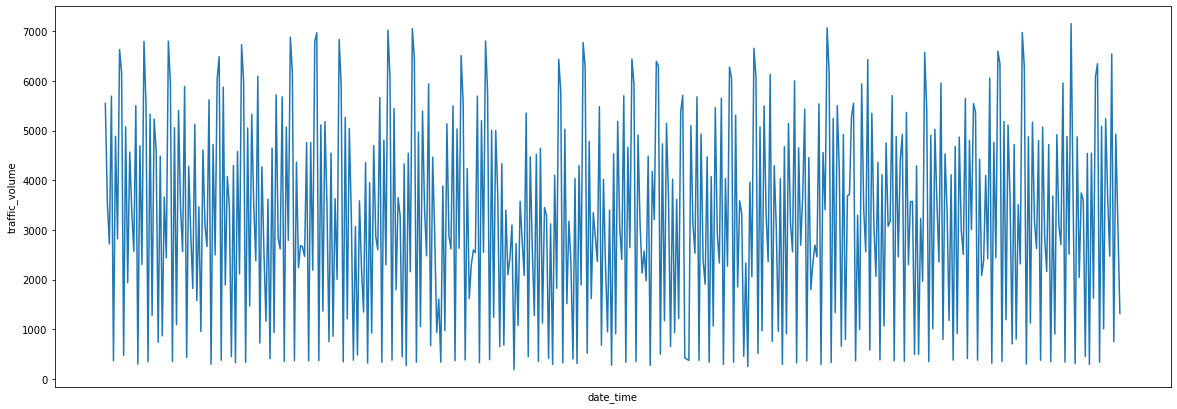

In [33]:
show_plot(data = ds.sort_index(ascending=True).iloc[:5000:10, :], show_ticks=False)

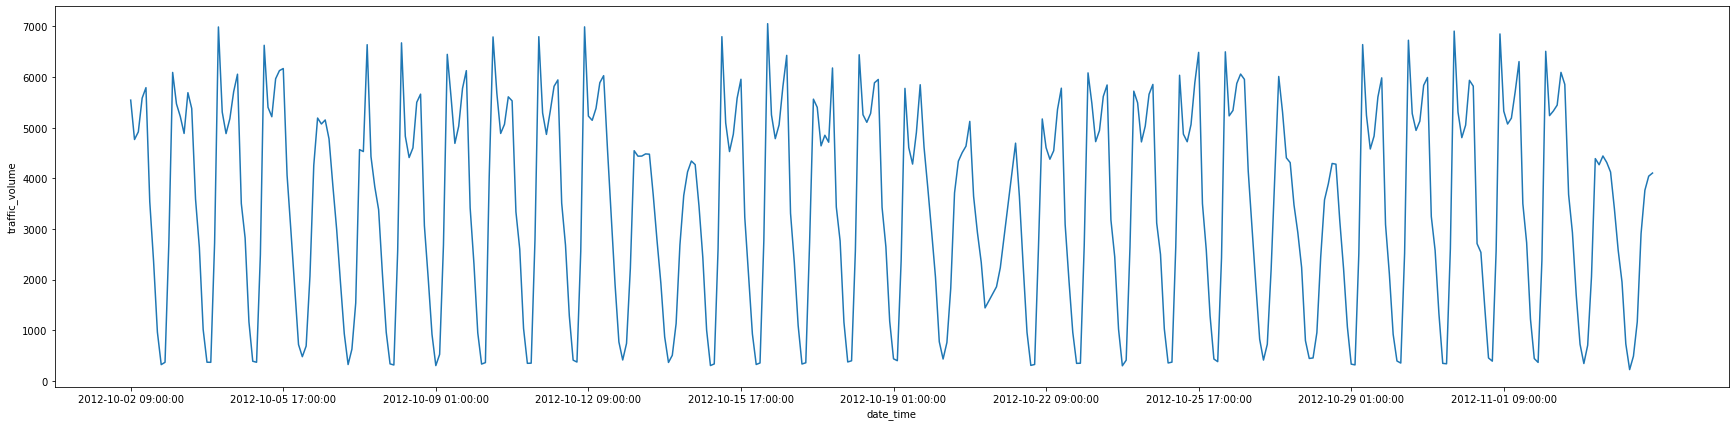

In [12]:
show_plot(data = ds.sort_index(ascending=True).iloc[:800:2, :], show_ticks=True, size=(30,7))

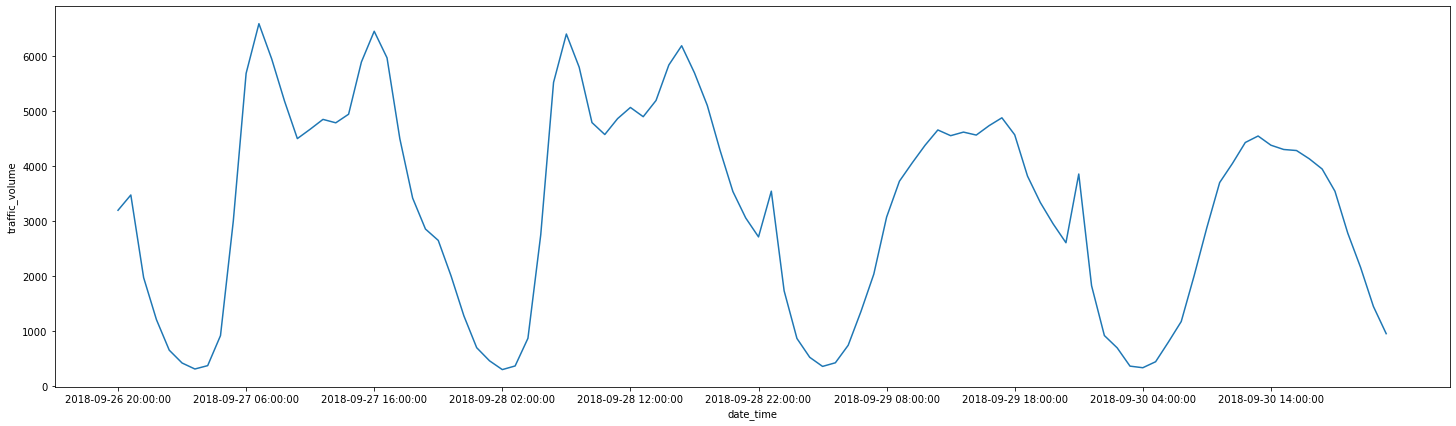

In [13]:
show_plot(data = ds.sort_index(ascending=True).iloc[-100::1, :],size=(25,7))

### Тут хорошо прослеживаются дневные колебания, видно, что в день наблюдаются два пика: утром и вечером. Ночью траффик почти нулевой

In [30]:
ds[~(ds['holiday'] == "None")].head(35)

,holiday,temp,traffic_volume
date_time,,,
2012-10-08 00:00:00,Columbus Day,273.080,455.0
2012-11-12 00:00:00,Veterans Day,288.120,1000.0
2012-11-22 00:00:00,Thanksgiving Day,278.540,919.0
2012-12-25 00:00:00,Christmas Day,264.400,803.0
2013-01-01 00:00:00,New Years Day,263.490,1439.0
2013-02-18 00:00:00,Washingtons Birthday,258.960,556.0
2013-05-27 00:00:00,Memorial Day,286.370,863.0
2013-07-04 00:00:00,Independence Day,290.080,1060.0
2013-08-22 00:00:00,State Fair,297.420,661.0


### Странно, что иногда Новый год стоит 2 января, или рождество 26. Проставим Новый год, Рождество, День независимости, а отстальные None, т.к. похоже у них плавающие даты

In [15]:
for christmas_day in pd.date_range(datetime.fromisoformat('2012-12-25 00:00:00'), datetime.fromisoformat('2018-12-25 00:00:00'),freq="Y"):
    if christmas_day not in ds:
        break
    if np.isnan(ds[christmas_day]['holiday']):
        ds[christmas_day]['holiday'] = 'Christmas Day'

for new_year in pd.date_range(datetime.fromisoformat('2013-01-01 00:00:00'), datetime.fromisoformat('2019-01-01 00:00:00'),freq="Y"):
    if new_year not in ds:
        break
    if np.isnan(ds[new_year]['holiday']):
        ds[new_year]['holiday'] = 'New Years Day'
        
for independence_day in pd.date_range(datetime.fromisoformat('2013-07-04 00:00:00'), datetime.fromisoformat('2019-07-04 00:00:00'),freq="Y"):
    if independence_day not in ds:
        break
    if np.isnan(ds[independence_day]['holiday']):
        ds[independence_day]['holiday'] = 'Independence Day'
        
ds['holiday'].fillna('None', inplace=True)

In [16]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52551 entries, 2012-10-02 09:00:00 to 2018-09-04 05:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         52551 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


### Посмотрим на трафик перед рождеством

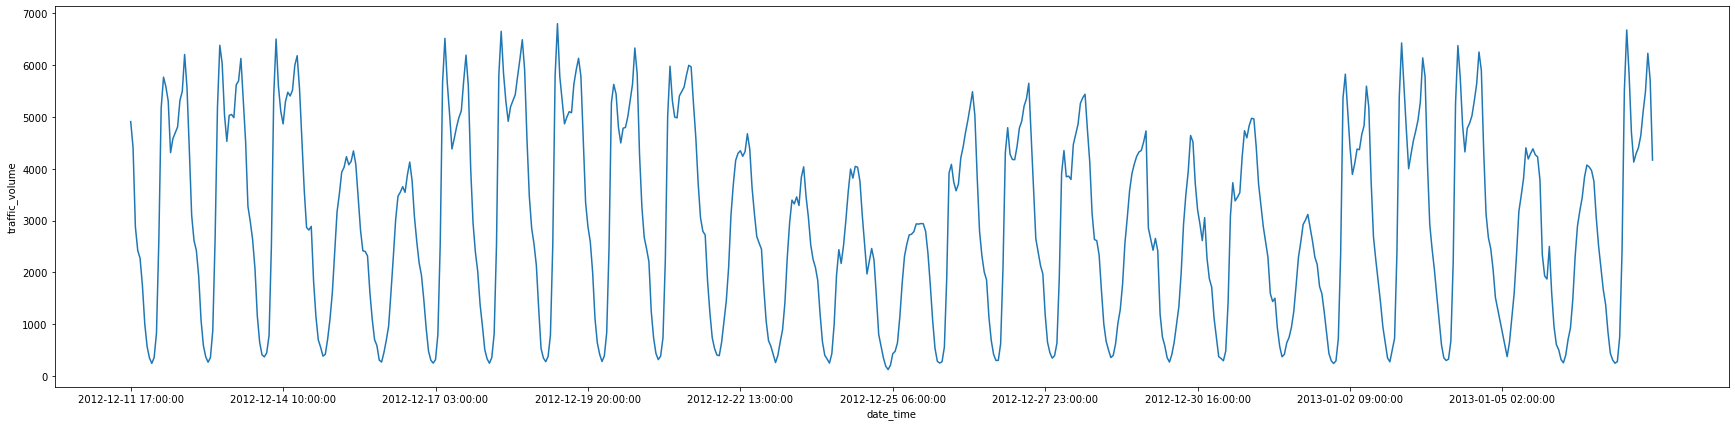

In [17]:
christmas_index = ds.index.get_loc('2012-12-25 00:00:00')
show_plot(data = ds.sort_index(ascending=True).iloc[(christmas_index - 250):christmas_index + 400],size=(30,7))

### Видно, что в рождество и в новый год трафик падет примерно в два раза и за три для до рождества наблюдается постепенный спад. 

### Проверим еще данные на выбросы

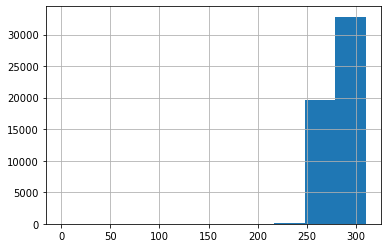

In [24]:
ds['temp'].hist()

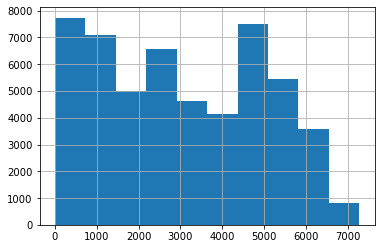

In [26]:
ds['traffic_volume'].hist()

### Выдим что у температуры есть выброс, либо в какой-то из дней температура была 0 по Кельвину. Заменим средними значениями все что ниже 200 (данные из Миннесоты, думаю, до -40 еще может быть, ниже уже врядли)

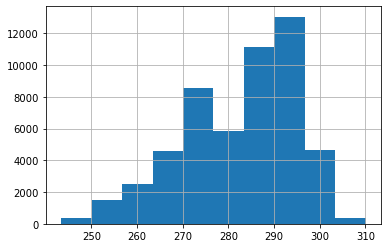

In [28]:
ds['temp'] = ds['temp'].apply(lambda x: x if x > 200 else ds['temp'].mean())
ds['temp'].hist()

### Теперь можно начинать моделирование

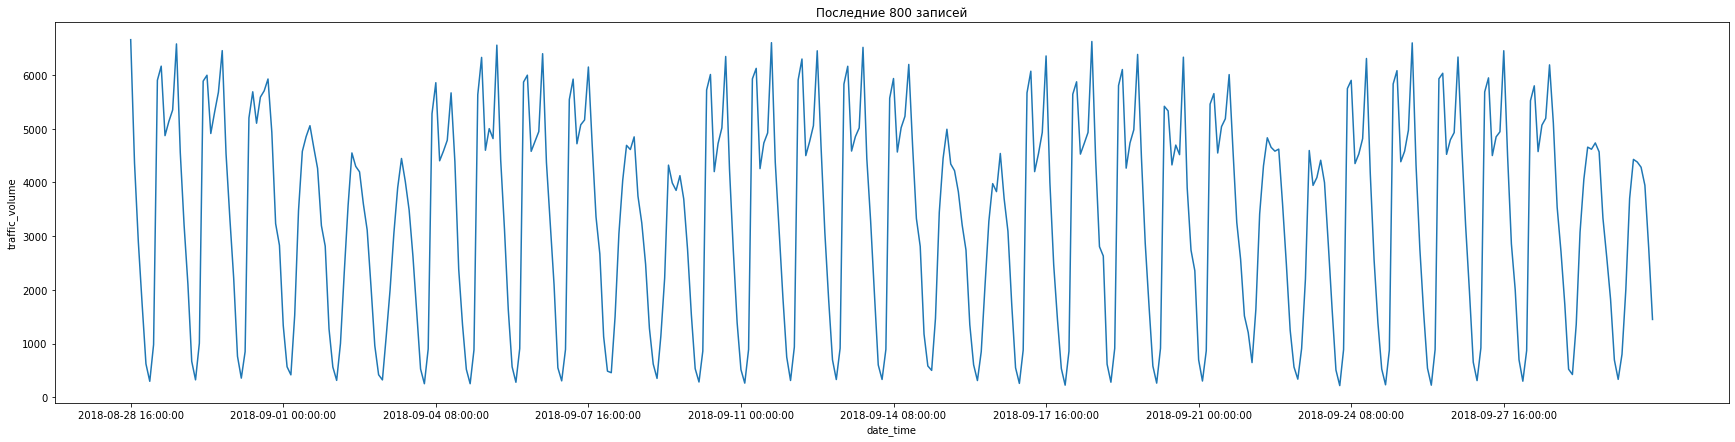

In [34]:
show_plot(data = ds.sort_index(ascending=True).iloc[-800::2, :], show_ticks=True, size=(30,7), title="Последние 800 записей")

In [40]:
hours_in_2_weeks = 24 * 14
test = ds.sort_index(ascending=True).iloc[-hours_in_2_weeks::, :]
train = ds.sort_index(ascending=True).iloc[:-hours_in_2_weeks:, :]
print("Train shape: {0} test shape: {1}".format(train.shape, test.shape))

Train shape: (52215, 3) test shape: (336, 3)


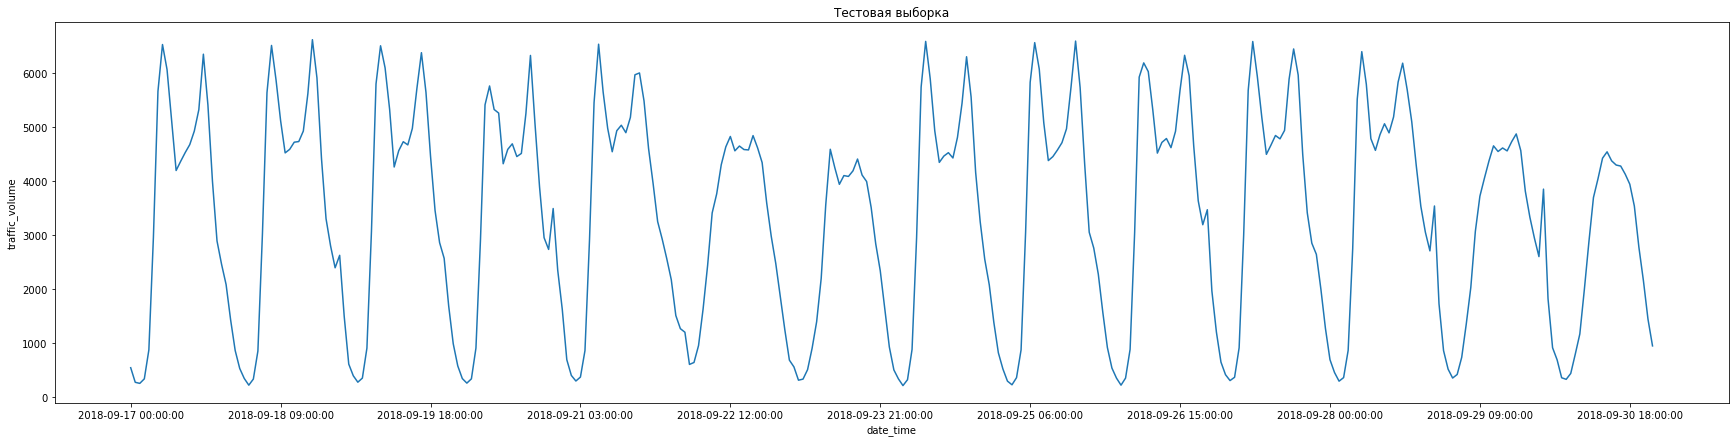

In [42]:
show_plot(data = test, show_ticks=True, size=(30,7), title="Тестовая выборка")